# Information-based learning

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from typing import List, Dict

## 1. Util functions

### DataSet wrapper

In [78]:
class Feature: 
    def __init__(self, D, f):
        self._D = D
        self._f = f
    
    def filter(self, l): 
        return Feature(self._D[self._D[self._f] == l], self._f)
    
    def IsHomogenous(self) -> bool:
        return self._D[self._f].nunique() == 1
    
    @property
    def Mode(self) -> str:
        return self._D[self._f].mode().iloc[0]
    
    @property
    def levels(self) -> List[str]:
        return self._D[self._f].unique()
    
    @property
    def rows(self) -> int:
        return self._D.shape[0]

class DataSet:
    def __init__(self, D: pd.DataFrame, t: str):
        self._D = D
        self._t = t

    def feature(self, feature) -> Feature: 
        return Feature(self._D, feature)
    
    def desc(self, feature) -> Feature: 
        return Feature(self._D, feature)
    
    def target(self) -> Feature: 
        return Feature(self._D, self._t)
    
    def filter(self, f, l): 
        return DataSet(self._D[self._D[f] == l], self._t)
    
    @property
    def rows(self) -> int:
        return self._D.shape[0]

    @property
    def df(self): 
        return self._D 

## 3. ID3 Algorithm

#### 3.1 Entropy functions

In [79]:
def P(l, f: Feature):
    return f.filter(l).rows / f.rows

def H(D: DataSet) -> float:
    entropy = lambda P: P * np.log2( P )
    t = D.target()
    return -sum([ entropy( P(l, t) ) for l in t.levels])

def REM(desc_feature: str, D: DataSet) -> float: 
    d = D.feature(desc_feature)
    
    # sum ( weight of level * entropy of level) 
    return sum([ P(l, d) * H(D.filter(desc_feature, l)) for l in d.levels])

#### 3.2 Tree datastructure

In [80]:
class Node:
    def show(self, indent=0) -> str: 
        pass
    
    def predict(self, instance: pd.Series):
        pass

class Leaf(Node): 
    def __init__(self, feature):
        self.feature = feature

    def show(self, indent=0) -> str: 
        print(f"{indent*' '}- Leaf: {self.feature}")

    def predict(self, _): 
        return self.feature

class Composite(Node): 
    def __init__(self, feature):
        self.feature = feature
        self.children: Dict[Any, Node] = {}

    def add(self, option, node):
        self.children[option] = node

    def mode(self, option):
        self._mode = option

    def show(self, indent=0) -> str: 
        print(f"{indent*' '}Node: {self.feature}")
        for option in self.children:
            print(f"{indent*' '}- Option: {option}")
            self.children[option].show(indent+4)

    def predict(self, instance: pd.Series): 
        val = instance[self.feature]
        if(val in self.children):
            return self.children[val].predict(instance)
        else:
            return self.children[self._mode].predict(instance)
        

#### 3.3 Algorithm

In [81]:
def ID3(d: List[str], D: DataSet) -> Node:
     
    if(D.rows < 1): 
        raise Exception("DataSet is empty.") 
    
    if(len(d) < 1): 
        return Leaf( D.target().Mode )
    
    if(D.target().IsHomogenous()):
        return Leaf( D.target().levels[0] )

    MAX_IG = pd.Series(
        [ H(D) - REM(f, D) for f in d], 
        index=d
    ).idxmax()

    decision_node = Composite(MAX_IG)
    
    modeDensity = 0
    for l in D.df[MAX_IG].unique():
        partition = D.filter(MAX_IG, l)

        child = D.target().Mode if partition.rows < 1 else ID3(list(filter(lambda l: l != MAX_IG, d)), partition)
        decision_node.add(l, child)

        pDensity = partition.rows / D.rows
        if(pDensity > modeDensity):
            decision_node.mode(l)
            modeDensity = pDensity

    return decision_node

## 4. Spam-ham example

In [82]:
data = [
    [367,True,False,True,'SPAM'],
    [489,True,True,False,'SPAM'],
    [541,True,True,False,'SPAM'],
    [693,False,True,True,'HAM'],
    [782,False,False,False,'HAM'],
    [976,False,False,False,'HAM'],
] 
features = ['ID', 'Suspicious words', 'Unknown sender', 'Contains images', 'Class']
spam_emails = pd.DataFrame(data, columns=features)

spam_emails

,ID,Suspicious words,Unknown sender,Contains images,Class
0,367,True,False,True,SPAM
1,489,True,True,False,SPAM
2,541,True,True,False,SPAM
3,693,False,True,True,HAM
4,782,False,False,False,HAM
5,976,False,False,False,HAM


In [83]:
t: str = 'Class'
d: List[str] = features[1:4]
D: DataSet = DataSet(spam_emails, t='Class')

In [84]:
# Information Gain
# IG = H(target_feature, D) - REM(descriptive_feature, D)
pd.Series(
    [ H(D) - REM(f, D) for f in d], 
    index=d
)

Suspicious words    1.000000
Unknown sender      0.081704
Contains images     0.000000
dtype: float64

#### Algorithm

In [85]:
tree = ID3(d, D)
tree.show()

Node: Suspicious words
- Option: True
    - Leaf: SPAM
- Option: False
    - Leaf: HAM


In [86]:
new_record = pd.Series({'Suspicious words': True, 'Unknown sender': False, 'Contains images': True})
tree.predict(new_record)

'SPAM'

## 5. Real world dataset

### Setup 

In [87]:
df = pd.read_csv('../../datasets/drugs.decision-trees.csv', sep=',', names=["Age","Sex", "BP", "Cholesterol", "Na_to_K", "Drug"], header=0)
df['AgeGroup'] = pd.cut(df['Age'], bins=range(10, 80, 5), right=False, labels=False) # age range is between 15 and 74

d = ["Age", "Sex", "BP", "Cholesterol"]
t = 'Drug'

df.head(5)


,Age,Sex,BP,Cholesterol,Na_to_K,Drug,AgeGroup
0,23,F,HIGH,HIGH,25.355,drugY,2
1,47,M,LOW,HIGH,13.093,drugC,7
2,47,M,LOW,HIGH,10.114,drugC,7
3,28,F,NORMAL,HIGH,7.798,drugX,3
4,61,F,LOW,HIGH,18.043,drugY,10


### Data check

In [88]:
categorial_cols = ["Age", "AgeGroup", "Sex", "BP", "Cholesterol"]
headers = ["feature","count", "% miss.", "card.", "Mode", "Mode freq.", "Mode %", "2nd Mode", "2nd Mode freq.", "2nd Mode %"]
report = []
for feature in categorial_cols:
    report.append([
        feature,
        df[feature].size,
        df[feature].isnull().sum() / df[feature].size,
        df[feature].nunique(),
        df[feature].mode().values[0],
        df[feature].value_counts().max(),
        (df[feature].value_counts().max() / df[feature].size) * 100,
        df[feature].value_counts().index[1],
        df[feature].value_counts().iloc[1],
        (df[feature].value_counts().iloc[1] / df[feature].size) * 100,
    ])
pd.DataFrame(report, columns=headers)

,feature,count,% miss.,card.,Mode,Mode freq.,Mode %,2nd Mode,2nd Mode freq.,2nd Mode %
0,Age,200,0.0,57,47,8,4.0,23,7,3.5
1,AgeGroup,200,0.0,12,7,23,11.5,2,21,10.5
2,Sex,200,0.0,2,M,104,52.0,F,96,48.0
3,BP,200,0.0,3,HIGH,77,38.5,LOW,64,32.0
4,Cholesterol,200,0.0,2,HIGH,103,51.5,NORMAL,97,48.5


<Axes: title={'center': 'Drug'}, xlabel='Drug'>

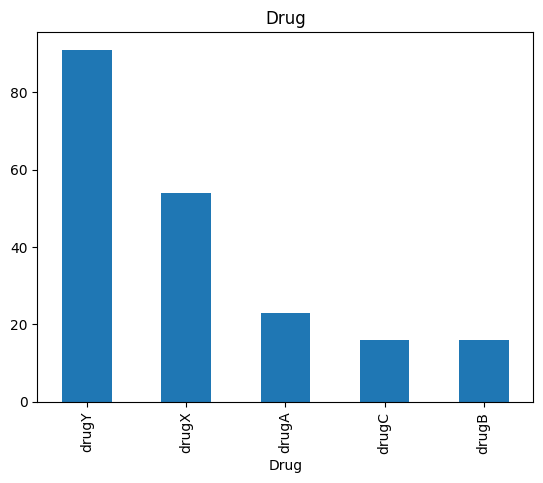

In [89]:
df['Drug'].value_counts().plot(kind='bar', title='Drug')

In [90]:
# new_record = pd.Series({"AgeGroup": 47, "Sex": "M", "BP": "LOW", "Cholesterol": "HIGH"})
# tree.predict(new_record)

## 6. Real world dataset II

In [91]:
features = ['buying price', 'maintenance cost', 'nr of doors', 'nr of persons', 'lug boot', 'safety', 'decision']
df = pd.read_csv('../../datasets/car_evaluation.decision-trees.csv', sep=',', names=features, header=0)

d = features[:-1]
t = 'decision'

df.shape

(1727, 7)

## 7. Validation

In [92]:
train, test = train_test_split(df, test_size=0.3) 

D: DataSet = DataSet(train, t)

tree = ID3(d, D)
test['Pred'] = df.apply(lambda x: tree.predict(x), axis=1)
test.head(5)

,buying price,maintenance cost,nr of doors,nr of persons,lug boot,safety,decision,Pred
761,high,low,2,2,big,low,unacc,unacc
348,vhigh,low,2,more,big,med,acc,unacc
1508,low,high,5more,more,big,low,unacc,unacc
1512,low,med,2,2,small,med,unacc,unacc
1603,low,med,5more,4,small,high,good,vgood


In [93]:
train, test = train_test_split(df, test_size=0.1) 

D: DataSet = DataSet(train, t)

tree = ID3(d, D)

test['Pred'] = df.apply(lambda x: tree.predict(x), axis=1)
test.head(5)

,buying price,maintenance cost,nr of doors,nr of persons,lug boot,safety,decision,Pred
1678,low,low,4,2,med,high,unacc,unacc
836,high,low,5more,2,small,low,unacc,unacc
1358,low,vhigh,4,4,small,low,unacc,unacc
92,vhigh,vhigh,5more,4,med,low,unacc,unacc
842,high,low,5more,2,big,low,unacc,unacc


In [94]:
# Create a new DataFrame with unique 'Target' levels
accuracy_df = pd.DataFrame(test[t].unique(), columns=[t])

# Calculate the count of correct and incorrect predictions
accuracy_df['Correct'] = accuracy_df[t].apply(lambda x: ((test[t] == x) & (test[t] == x)).sum())
accuracy_df['Incorrect'] = accuracy_df[t].apply(lambda x: ((test[t] == x) & (test[t] != x)).sum())
accuracy_df['Accuracy'] = round(accuracy_df['Correct'] / (accuracy_df['Correct'] + accuracy_df['Incorrect']),3)

accuracy_df.loc[len(accuracy_df.index)] = ['Total', accuracy_df['Correct'].sum(), accuracy_df['Incorrect'].sum(), accuracy_df['Accuracy'].mean()] 

accuracy_df

,decision,Correct,Incorrect,Accuracy
0,unacc,120,0,1.0
1,acc,44,0,1.0
2,vgood,3,0,1.0
3,good,6,0,1.0
4,Total,173,0,1.0
